# Generation of Datasets

In [32]:
import os

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import joblib
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle

In [2]:
def remove_outliers(df, cols):
    for col in cols:
        df = df[np.abs(stats.zscore(df[col]) <= 3)].reset_index(drop=True)
    return df

def generate_bpl_data(pop, bpl, bpl_cr):
    states = bpl['State.UT'].unique()
    states
    for state in states:
        perc = bpl[(bpl['State.UT'] == state) & (bpl['year'] == 2011)]['percent'].values[0]
        for year in range(2012, 2020):
            perc = perc + bpl_cr
            new_entry = pd.DataFrame({'State.UT':[state], 'percent':[perc], 'year':[year]})
            bpl = pd.concat([bpl, new_entry], axis=0)

    state = "ANDHRA PR"

    bpl = bpl[~((bpl['year'] > 2013) & (bpl['State.UT'] == state))]

    bpl = pd.merge(bpl, pop, on=['State.UT', 'year'])
    bpl['bpl_pop'] = bpl['percent'] * bpl['Population'] / 100
    bpl = bpl[(bpl['bpl_pop'] > 0)]
    bpl['log_bpl_pop'] = np.log1p(bpl['Population'])
    return bpl

Loading rice and wheat consumption datasets and removal of outliers in them.

In [3]:
rice = pd.read_excel("data/rice.xlsx")
wheat = pd.read_excel("data/wheat.xlsx")
print (rice.shape)

rice = remove_outliers(rice, ["offtake", "allotment"])
wheat = remove_outliers(wheat, ["offtake", "allotment"])
print (rice.shape)

(601, 5)
(586, 5)


Finding rice consuming and wheat consuming states

In [4]:
rice_summary = rice.groupby("State.UT").agg({"allotment":sum}).reset_index().\
                rename({"allotment":"rice_allotment"}, axis=1)
wheat_summary = wheat.groupby("State.UT").agg({"allotment":sum}).reset_index().\
                rename({"allotment":"wheat_allotment"}, axis=1)

rice_wheat = pd.merge(rice_summary, wheat_summary, on='State.UT', how='inner')
rice_wheat['perc_rice'] = rice_wheat['rice_allotment'] / (rice_wheat['rice_allotment'] + rice_wheat['wheat_allotment'])
rice_wheat['perc_wheat'] = rice_wheat['wheat_allotment'] / (rice_wheat['rice_allotment'] + rice_wheat['wheat_allotment'])

rice_wheat.head()

,State.UT,rice_allotment,wheat_allotment,perc_rice,perc_wheat
0,A&N ISLANDS,485.20,232.12,0.676407,0.323593
1,ANDHRA PR,49027.06,3712.78,0.929602,0.070398
2,ARUNACHAL,1843.87,210.01,0.897750,0.102250
3,ASSAM,29957.20,6564.82,0.820250,0.179750
4,BIHAR,52286.72,36073.22,0.591747,0.408253


Making total allotment and offtake from rice and wheat allotment-offtake state-year wise data

In [5]:
all_off = pd.merge(rice, wheat, on=['State.UT', 'year'], how='inner')
all_off['offtake'] = all_off["offtake_x"] + all_off["offtake_y"]
all_off['allotment'] = all_off['allotment_x'] + all_off['allotment_y']
all_off.drop(['offtake_x', 'offtake_y', 'allotment_x', 'allotment_y', 'zone_x', 'zone_y'], axis=1, inplace=True)
all_off['utilisation_ratio'] = all_off['offtake'] / all_off['allotment']
all_off = remove_outliers(all_off, ['offtake', 'allotment', 'utilisation_ratio'])
all_off.head()

,State.UT,year,offtake,allotment,utilisation_ratio
0,A&N ISLANDS,2003,22.39,48.77,0.459094
1,ARUNACHAL,2003,104.96,145.33,0.722218
2,ASSAM,2003,1510.92,2042.99,0.739563
3,BIHAR,2003,1424.66,5699.26,0.249973
4,CHANDIGARH,2003,1.72,87.82,0.019586


### Year over year and state total_ao analysis

In [6]:
year_total_ao = all_off.groupby('year').agg({'allotment':sum, 'offtake':sum}).reset_index()
year_total_ao.head()

,year,allotment,offtake
0,2003,33339.66,17375.66
1,2004,34330.76,18574.06
2,2005,48210.39,25269.57
3,2006,48333.61,27877.11
4,2007,38947.82,33513.04


In [7]:
year_total_ao.to_excel('data/year_total_ao.xlsx')

In [8]:
import plotly.graph_objects as go

In [9]:
dif = go.Figure()

In [10]:
state_total_ao = all_off.groupby('State.UT').agg({'allotment':sum, 'offtake':sum}).reset_index()
state_total_ao.head()

,State.UT,allotment,offtake
0,A&N ISLANDS,717.32,300.19
1,ANDHRA PR,51873.18,45778.81
2,ARUNACHAL,2053.88,1652.67
3,ASSAM,36522.02,31546.01
4,BIHAR,58594.23,35139.06


In [11]:
state_total_ao.to_excel('data/state_total_ao.xlsx')

**The analysis in the below cell are not used anywhere in the paper**

In [12]:
ur = pd.read_excel("data/utilisation_ratio_state_wise_2010_2019.xlsx")
state_ao = pd.read_excel("data/state_ao 2003-19.xlsx")

#Getting road length data
road_l = pd.read_excel("data/Road Length 2010-16.XLSX")
road_l = pd.melt(road_l, var_name='year', value_name='ro_length', id_vars='State.UT')
road_l = road_l.dropna()
road_l['year'] = road_l['year'].astype(int)
road_l['ro_log_length'] = np.log1p(road_l['ro_length'])
road_l = remove_outliers(road_l, ["ro_length", "ro_log_length"])
road_l.head()

#Getting state highway length
sh_l = pd.read_excel("data/SH Length 2011-16.xlsx")
sh_l = pd.melt(sh_l, var_name='year', value_name='sh_length', id_vars='State.UT')
sh_l = sh_l.dropna()
sh_l['sh_log_length'] = np.log1p(sh_l['sh_length'])
sh_l['year'] = sh_l['year'].astype(float)
sh_l = remove_outliers(sh_l, ["sh_log_length", "sh_length"])

#Getting railway length data
rw_l = pd.read_excel("data/Railway Length 2011-17.xlsx")
rw_l = pd.melt(rw_l, var_name='year', value_name='rw_length', id_vars='State.UT')
rw_l = rw_l.dropna()
rw_l['rw_log_length'] = np.log1p(rw_l['rw_length'])
rw_l['year'] = rw_l['year'].astype(float)
rw_l = remove_outliers(rw_l, ["rw_length", "rw_log_length"])

#Getting GSDP data
gsdp = pd.read_excel("data/GSDP Current Price 2011-20.xlsx")
gsdp = pd.melt(gsdp, var_name='year', value_name='gsdp', id_vars='State.UT')
gsdp['year'] = gsdp['year'].apply(lambda x: int(x[0:4]))
gsdp = gsdp.dropna()
gsdp['log_gsdp'] = np.log1p(gsdp['gsdp'])
gsdp.head()

,State.UT,year,gsdp,log_gsdp
0,A&N ISLANDS,2011,3978.431748,8.288894
1,ANDHRA PR,2011,379402.030000,12.846354
2,ARUNACHAL,2011,11062.690000,9.311424
3,ASSAM,2011,143174.910000,11.871829
4,BIHAR,2011,247143.960643,12.417730


DCP Data Prepearation

In [13]:
rice['grain'] = 'rice'
wheat['grain'] = 'white'
df_dcp = pd.concat([rice, wheat], axis=0).reset_index()
rice.drop(['grain'], axis=1, inplace=True)
wheat.drop(['grain'], axis=1, inplace=True)
df_dcp['dcp'] = 0

dcp_status = pd.read_excel("data/DCP Status.xlsx")
dcp_status = dcp_status.dropna().reset_index(drop=True)

#wef - with effect from
indexes = []
for idx, row in dcp_status.iterrows():
    year = row['wef']
    state = row['State.UT']
    grain = row['grain']
    idx = df_dcp[(df_dcp['year'] >= year) & (df_dcp['State.UT'] == state) & (df_dcp['grain'] == grain)].index
    df_dcp['dcp'][idx] = 1    

df_dcp.sample(5)

df_dcp['utilisation_ratio'] = df_dcp['offtake'] / df_dcp['allotment']
df_dcp.dropna(inplace=True)
df_dcp = df_dcp[df_dcp['utilisation_ratio'] <= 1]
df_dcp = remove_outliers(df_dcp, ["utilisation_ratio"])

In [14]:
pop = pd.read_excel("data/projected_population_by_state_2012_2036.xlsx")
pop['log_pop'] = np.log1p(pop['Population'])

bpl_perc2011 = pd.read_excel("data/BPL data.xlsx")
bpl_perc2011.rename({"2011-12 Perc of Persons":"percent"}, axis=1, inplace=True)
bpl_perc2011['year'] = 2011

In [16]:
total_all_pop = pd.merge(all_off, pop, on=['State.UT', 'year'], how='inner')

total_all_pop.head()

,State.UT,year,offtake,allotment,utilisation_ratio,Population,log_pop
0,A&N ISLANDS,2011,20.41,40.60,0.502709,381000,12.850557
1,ARUNACHAL,2011,102.69,134.52,0.763381,1384000,14.140489
2,ASSAM,2011,2211.13,2914.49,0.758668,31206000,17.256121
3,BIHAR,2011,3802.68,5410.26,0.702865,104099000,18.460853
4,CHANDIGARH,2011,54.84,76.20,0.719685,1055000,13.869052


### Equation A

In [17]:
pop_alt_model = linear_model.LinearRegression().fit(total_all_pop[['Population']], total_all_pop['allotment'])

print (pop_alt_model.coef_, pop_alt_model.intercept_)

[4.82335241e-05] 88.87382471679757


In [18]:
est = sm.OLS(total_all_pop[['allotment']], sm.add_constant(total_all_pop[['Population']]))

a = est.fit().summary()
#print (a.as_latex())
a

/Users/arun/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              allotment   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     5435.
Date:                Mon, 21 Mar 2022   Prob (F-statistic):          4.47e-192
Time:                        18:23:21   Log-Likelihood:                -2178.4
No. Observations:                 297   AIC:                             4361.
Df Residuals:                     295   BIC:                             4368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.8738     28.649      3.102      0.002      32.492     145.256
Population  4.823e-05   6.54e-07     73.722      0.000    4.69e-05    4.95e-05
==============================================================================
Omnibus:                       22.514   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.518
Skew:                           0.537   Prob(JB):                     1.43e-07
Kurtosis:                       4.181   Cond. No.                     5.81e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.81e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
# pickle.dump(pop_alt_model, open('../model_hub/pop_alt_model.pkl', 'wb'))

### Equation B

Leasr BPL Change Rate  0.81


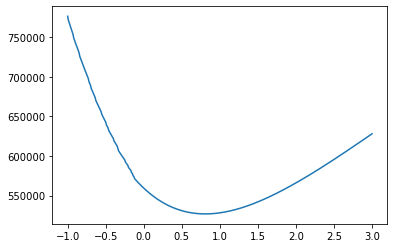

In [19]:
bpl_change_rate = []
ssr = []
for bpl_cr in np.arange(-1, 3.01, 0.01):
    bpl_cr = round(bpl_cr, 2)
    bpl = generate_bpl_data(pop, bpl_perc2011, bpl_cr)
    tbp = pd.merge(all_off, bpl, on=['State.UT', 'year'], how='inner')
    model = linear_model.LinearRegression().fit(tbp[['bpl_pop']], tbp['allotment'])
    pred = model.predict(tbp[['bpl_pop']])
    ssr.append(mean_squared_error(pred, tbp['allotment']))
    bpl_change_rate.append(bpl_cr)

bpl_cr = bpl_change_rate[ssr.index(min(ssr))]
print ("Leasr BPL Change Rate ", bpl_cr)

plt.plot(bpl_change_rate, ssr)

In [21]:
bpl_cr

0.81

In [22]:
bpl_cr = 0.81

In [23]:
bpl = generate_bpl_data(pop, bpl_perc2011, bpl_cr)
tbp = pd.merge(all_off, bpl, on=['State.UT', 'year'], how='inner')

In [24]:
bpl_alt_fit = linear_model.LinearRegression().fit(tbp[['bpl_pop']], tbp['allotment'])

In [25]:
est = sm.OLS(tbp[['allotment']], sm.add_constant(tbp[['bpl_pop']]))

a = est.fit().summary()
#print (a.as_latex())
a

/Users/arun/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              allotment   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1201.
Date:                Mon, 21 Mar 2022   Prob (F-statistic):          7.58e-104
Time:                        18:24:52   Log-Likelihood:                -2281.8
No. Observations:                 285   AIC:                             4568.
Df Residuals:                     283   BIC:                             4575.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        332.2602     53.966      6.157      0.000     226.035     438.485
bpl_pop        0.0002   4.84e-06     34.660      0.000       0.000       0.000
==============================================================================
Omnibus:                       96.346   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.967
Skew:                           1.455   Prob(JB):                     7.39e-71
Kurtosis:                       7.328   Cond. No.                     1.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Forecasts for futures

In [26]:
r = rice.copy()
w = wheat.copy()
r.rename({"allotment":"rice_allotment"}, axis=1, inplace=True)
w.rename({"allotment":"wheat_allotment"}, axis=1, inplace=True)
r.drop(["zone", "offtake"], axis=1, inplace=True)
w.drop(["zone", "offtake"], axis=1, inplace=True)
rw = pd.merge(r, w, on=['State.UT', 'year'], how='inner')

rw['rice_perc'] = rw['rice_allotment'] / (rw['rice_allotment'] + rw['wheat_allotment'])
rw['wheat_perc'] = rw['wheat_allotment'] / (rw['rice_allotment'] + rw['wheat_allotment'])

rw['rice_moving_perc'] = 0
rw['wheat_moving_perc'] = 0

Calculat moving percentage

In [27]:
for year in range(2006, 2020):
    for state in list(rw['State.UT'].unique()):
        df2 = rw[((rw['State.UT'] == state) & ((rw['year'] < year) & (rw['year'] >= year-3)))]
        r_m_p, w_m_p = df2['rice_perc'].mean(), df2['wheat_perc'].mean()
        idx = rw[((rw['State.UT'] == state) & (rw['year'] == year))].index
        if len(idx) > 0:
            rw['rice_moving_perc'][idx] = r_m_p
            rw['wheat_moving_perc'][idx] = w_m_p

rw.shape

(561, 8)

In [28]:
rw = rw[(rw['rice_moving_perc'] > 0) & (rw['wheat_moving_perc'] > 0)]
rw.shape

(465, 8)

In [29]:
bpl_cr = 0.81

bpl_pop = generate_bpl_data(pop, bpl_perc2011, bpl_cr)

bpl.head()

,State.UT,percent,year,Population,log_pop,bpl_pop,log_bpl_pop
0,A&N ISLANDS,1.00,2011,381000,12.850557,3810.0,12.850557
1,ANDHRA PR,9.20,2011,84581000,18.253220,7781452.0,18.253220
2,ARUNACHAL,34.67,2011,1384000,14.140489,479832.8,14.140489
3,ASSAM,31.98,2011,31206000,17.256121,9979678.8,17.256121
4,BIHAR,33.74,2011,104099000,18.460853,35123002.6,18.460853


In [30]:
def calculate_adj_r_squared(n, p, r2):
    a = (n - 1) / (n - p - 1)
    b = (1 - r2 **2) * a
    return 1 - b

## Equation C

In [31]:
r_bp = pd.merge(rw, bpl_pop, on=['State.UT', 'year'], how='inner')
r_bp = remove_outliers(r_bp, ["bpl_pop", "rice_allotment", "rice_moving_perc", "wheat_moving_perc"])

rice_bpl_pop_fit = linear_model.LinearRegression()
rice_bpl_pop_fit = rice_bpl_pop_fit.fit(r_bp[['Population', 'bpl_pop', 'rice_moving_perc']], r_bp['rice_allotment'])
rice_bpl_pop_fit.coef_

array([1.80685613e-05, 3.11026643e-05, 1.41455778e+03])

In [33]:
joblib.dump(rice_bpl_pop_fit, 'models/rice_bpl_pop_fit.joblib')

['models/rice_bpl_pop_fit.joblib']

In [32]:
x2 = sm.add_constant(r_bp[['Population', 'bpl_pop', 'rice_moving_perc']])

est = sm.OLS(r_bp[['rice_allotment']], x2)

a = est.fit().summary()

a

/Users/arun/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         rice_allotment   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     302.6
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           8.80e-87
Time:                        15:15:13   Log-Likelihood:                -2097.6
No. Observations:                 279   AIC:                             4203.
Df Residuals:                     275   BIC:                             4218.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -801.3456     76.499    -10.475      0.000    -951.944    -650.747
Population        1.807e-05   2.49e-06      7.253      0.000    1.32e-05     2.3e-05
bpl_pop            3.11e-05   9.35e-06      3.328      0.001    1.27e-05    4.95e-05
rice_moving_perc  1414.5578    101.851     13.888      0.000    1214.051    1615.065
==============================================================================
Omnibus:                        4.396   Durbin-Watson:                   1.720
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.071
Skew:                           0.261   Prob(JB):                        0.131
Kurtosis:                       3.278   Cond. No.                     1.96e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Equation D

In [34]:
w_bp = pd.merge(rw, bpl_pop, on=['State.UT', 'year'], how='inner')
w_bp = remove_outliers(w_bp, ["bpl_pop", "wheat_allotment", "wheat_moving_perc", "wheat_moving_perc"])

wheat_bpl_pop_fit = linear_model.LinearRegression()
wheat_bpl_pop_fit = wheat_bpl_pop_fit.fit(w_bp[['Population', 'bpl_pop', 'wheat_moving_perc']], w_bp['wheat_allotment'])

In [35]:
joblib.dump(wheat_bpl_pop_fit, 'models/wheat_bpl_pop_fit.joblib')

['models/wheat_bpl_pop_fit.joblib']

In [36]:
x2 = sm.add_constant(w_bp[['Population', 'bpl_pop', 'wheat_moving_perc']])

est = sm.OLS(w_bp[['wheat_allotment']], x2)

a = est.fit().summary()

a

/Users/arun/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        wheat_allotment   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     414.0
Date:                Tue, 17 Aug 2021   Prob (F-statistic):          8.12e-102
Time:                        15:16:24   Log-Likelihood:                -2073.0
No. Observations:                 280   AIC:                             4154.
Df Residuals:                     276   BIC:                             4169.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -443.3584     42.406    -10.455      0.000    -526.839    -359.877
Population         1.804e-05   2.04e-06      8.847      0.000     1.4e-05    2.21e-05
bpl_pop            1.268e-05   7.74e-06      1.638      0.103   -2.56e-06    2.79e-05
wheat_moving_perc  1243.5287     86.888     14.312      0.000    1072.481    1414.576
==============================================================================
Omnibus:                        4.446   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                5.826
Skew:                           0.005   Prob(JB):                       0.0543
Kurtosis:                       3.707   Cond. No.                     1.62e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""